In [1]:
import pandas as pd
import os
import warnings
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

In [2]:
warnings.filterwarnings("ignore")

In [3]:
working_dir = os.getcwd()
rel_path = r"project_resources\chembl_molekuly.csv"
molekuly_csv_abs_file_path = os.path.join(working_dir, rel_path)
#loads csv file from directory

In [4]:
#dir for useful stuff for the actual essay
rel_path = r"project_results\graphs"
project_results_graphs = os.path.join(working_dir, rel_path)

In [5]:
df = pd.read_csv(molekuly_csv_abs_file_path, sep=";")
#df.head()

In [6]:
df = pd.read_csv(molekuly_csv_abs_file_path, sep=";")
statistika = df["Standard Type"].value_counts()
#print(statistika)

In [7]:
result = df[(df["Standard Type"] == "t1/2") | (df["Standard Type"] == "T1/2")]
t_half_rel_path = r"project_resources\t_half.csv"
t_half_abs_path = os.path.join(working_dir, t_half_rel_path)
result.to_csv(t_half_abs_path, index=False)
#creates "t_half.csv" in current dir
t_half = pd.read_csv(t_half_abs_path)
#and then loads it

In [8]:
client = new_client
list_smiles = []
list_chembl_id = t_half["Molecule ChEMBL ID"]
for chembl_id in list_chembl_id:
    molecule = client.molecule
    compound = molecule.filter(chembl_id=chembl_id)[0]
    list_smiles.append(compound['molecule_structures']["canonical_smiles"])
#print(list_smiles)

In [9]:
#takes a list of smiles strings,output is a corresponding Morgan fingerprint as a list
list_fingerprint = []
for smi in list_smiles:
    mol = Chem.MolFromSmiles(smi)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=True, radius=2, nBits = 124)
    vector = np.array(fingerprint)
    list_fingerprint.append(vector)
    #print(list_fingerprint)

In [10]:
#data sets filtering for ML
t_half = pd.read_csv(t_half_abs_path)

t_half = np.array(t_half['Standard Value'])
t_half_float = t_half.astype(float)
t_filtered = t_half_float[t_half>0]

array_fingerprint = np.array(list_fingerprint)
array_fingerprint_filtered = array_fingerprint[t_half>0]

In [11]:
# x su len fingerprint ako jeden numpy array,
# y su len t_half hodnoty ako jeden numpy array, pouzit len molekuly kde existuje aj X aj y hodnota
x = array_fingerprint_filtered
y = t_filtered
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
idx_train, idx_test = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42)

x_train = x[idx_train]
x_test = x[idx_test]

y_train = y[idx_train]
y_test = y[idx_test]

array_fingerprint_filtered_train = array_fingerprint_filtered[idx_train]
array_fingerprint_filtered_test = array_fingerprint_filtered[idx_test]

print(t_filtered.shape, array_fingerprint_filtered.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(70,) (70, 124) (56, 124) (14, 124) (56,) (14,)


In [12]:
def model_choice(ml_type):
    
    if ml_type == 'linear':
        reg = linear_model.ElasticNet(alpha=0.001, l1_ratio=1)
        plot_title = "Linear"
        
    if ml_type == 'KRR':
        reg = KernelRidge(alpha=0.1)
        plot_title = "Kernel ridge regressor"
        
    if ml_type == 'RF':
        reg = RandomForestRegressor(max_depth=None, random_state=0)
        plot_title = "Random forest regressor"
        
    if ml_type == 'GB':
        reg = GradientBoostingRegressor(random_state=1, loss='absolute_error', max_depth=5, n_estimators=1000)
        plot_title = "Gradient boosting regressor"
        
    if ml_type == 'ANN':
        reg = MLPRegressor(random_state=1, max_iter=5000, learning_rate_init=0.001, alpha=0, hidden_layer_sizes=[10,10])
        plot_title = "Limited-memory BFGS"
    print(f"using ML type {ml_type}")
    
    return reg, plot_title

In [13]:
def mach_learn(x_train, x_test, y_train, y_test, reg, plot_title):
    # výcvik strojoveho modelu
    reg = reg.fit(x_train, y_train)
    # predict training set
    y_train_predict = reg.predict(x_train)
    # predict test set
    y_test_predict = reg.predict(x_test)
    #error train je pre info, test je dolezita
    train_error = np.mean(np.abs(y_train_predict-y_train))
    test_error = np.mean(np.abs(y_test_predict-y_test))
    print(f"MAE train: {train_error:.4f}")
    print(f"MAE test: {test_error:.4f}")
    #print(np.abs(y_test_predict-y_test), f"length: {len(y_test_predict-y_test)}")

    # idealne data na diagonale
    #diag = np.linspace(-1, 3.5)

    #plot = plt.scatter(y_test, y_test_predict, edgecolors=None, c='b', alpha=0.2)
    #plt.plot(diag, diag, linestyle='dotted')
    #plt.xlim(-1, 3.5)
    #plt.ylim(-1, 3.5)
    #plt.ylabel('$t_{1/2}$ (predicted)')
    #plt.xlabel('$t_{1/2}$ (real)')
    #plt.suptitle(f"{plot_title}")
    #plt.savefig(os.path.join(project_results_graphs, plot_title))
    #plt.show()

In [14]:
# opakovat pre rozne strojove metody, porovnan chyby
#to display graphs, un-comment all rows in previous cell starting with plot or plt
type_ml_use = 'linear'
reg, plot_title = model_choice(type_ml_use)
mach_learn(x_train, x_test, y_train, y_test, reg, plot_title)

using ML type linear
MAE train: 0.2470
MAE test: 0.7197


In [15]:
type_ml_use = 'KRR'
reg, plot_title = model_choice(type_ml_use)
mach_learn(x_train, x_test, y_train, y_test, reg, plot_title)

using ML type KRR
MAE train: 0.2274
MAE test: 0.6352


In [16]:
type_ml_use = 'RF'
reg, plot_title = model_choice(type_ml_use)
mach_learn(x_train, x_test, y_train, y_test, reg, plot_title)

using ML type RF
MAE train: 0.3392
MAE test: 0.5554


In [17]:
type_ml_use = 'GB'
reg, plot_title = model_choice(type_ml_use)
mach_learn(x_train, x_test, y_train, y_test, reg, plot_title)

using ML type GB
MAE train: 0.2144
MAE test: 0.3618


In [18]:
type_ml_use = 'ANN'
reg, plot_title = model_choice(type_ml_use)
mach_learn(x_train, x_test, y_train, y_test, reg, plot_title)

using ML type ANN
MAE train: 0.2984
MAE test: 0.4429


In [19]:
def param_tuning(type_ml_use, reg):
    if type_ml_use == 'linear':
        param_grid = {
            'fit_intercept': [True], 
            'alpha': [1e-5, 1e-4, 1e-3, 1e-2], 
            'l1_ratio': [0, 0.1, 0.5, 0.9, 1]
        }
        reg = linear_model.ElasticNet()

    if type_ml_use=='KRR':
        param_grid= {
            "alpha": np.logspace(-4, 1, 20),
            "gamma": np.logspace(-14, 0, 20), 
            "kernel": ['linear', 'laplacian', 'rbf']
        }
        reg = KernelRidge()

    if type_ml_use=='GB':
        param_grid = {
            'n_estimators': [20, 200, 2000], 
            'learning_rate': [0.02, 0.05], 
            'max_depth': [1, 2, 3, 5], 
            'min_samples_leaf': [5, 10, 20], 
            'min_samples_split': [2, 5]
        }
        reg = GradientBoostingRegressor()

    if type_ml_use=='RF':
        param_grid = {
            'max_depth': [None, 2, 3, 5, 10], 
            'max_features': ['auto','sqrt', 'log2'], 
            'n_estimators': [10, 20, 50, 100, 200],
        }
        reg = RandomForestRegressor()

    if type_ml_use=='ANN':
        param_grid = {
            'learning_rate_init': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05], 
            'hidden_layer_sizes': [[5], [10], [20], [50], [5]*2, [10]*2, [20]*2, [50]*2, [5]*3, [10]*3]
        }
        reg = MLPRegressor()

    grid = GridSearchCV(reg, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=1), verbose=0)
    grid.fit(x_train, y_train)
    best_reg = grid.best_estimator_
    print(type_ml_use, str(grid.best_params_))
    # retrain on best hyperparameters
    best_reg.fit(x_train, y_train)
    # vypocitat novy MAE train, test po hyperparameter trainink
    y_train_predict = best_reg.predict(x_train)
    y_test_predict = best_reg.predict(x_test)
    train_error = np.mean(np.abs(y_train_predict-y_train))
    abs_error = np.abs(y_test_predict-y_test)
    test_error = np.mean(abs_error)
    print(f"MAE train: {train_error:.4f}")
    print(f"MAE test: {test_error:.4f}")
    
    plot = plt.scatter(tanimoto_similarities, abs_error, edgecolors=None, c='b', alpha=0.2)
    plt.xlabel('tanimoto similarities')
    plt.ylabel('abs error')
    plt.suptitle(f"{plot_title}")
    #plt.savefig(os.path.join(project_results_graphs, plot_title))
    plt.show()

In [20]:
def to_rdkit_fingerprint(fps):
    rdkit_fingerprints = []
    for prnt in fps:
        bitstring = "".join(prnt.astype(str))
        fp = DataStructs.cDataStructs.CreateFromBitString(bitstring)
        rdkit_fingerprints.append(fp)
    return rdkit_fingerprints

In [21]:
fps = to_rdkit_fingerprint(array_fingerprint_filtered_test)
fp2s = to_rdkit_fingerprint(array_fingerprint_filtered_train)
tanimoto_similarities = []
for x in fps:
    fpsx = []
    for y in fp2s:
        fpsx.append(DataStructs.TanimotoSimilarity(x,y))
    max_tanimoto = max(fpsx)
    tanimoto_similarities.append(max_tanimoto)
print(tanimoto_similarities, f"length: {len(tanimoto_similarities)}")

[0.810126582278481, 0.40625, 0.5692307692307692, 0.9137931034482759, 0.5679012345679012, 0.8833333333333333, 0.8571428571428571, 0.9154929577464789, 0.9193548387096774, 1.0, 0.6052631578947368, 0.3888888888888889, 0.8529411764705882, 0.3684210526315789] length: 14


using ML type linear
linear {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 1}
MAE train: 0.3531
MAE test: 0.4430


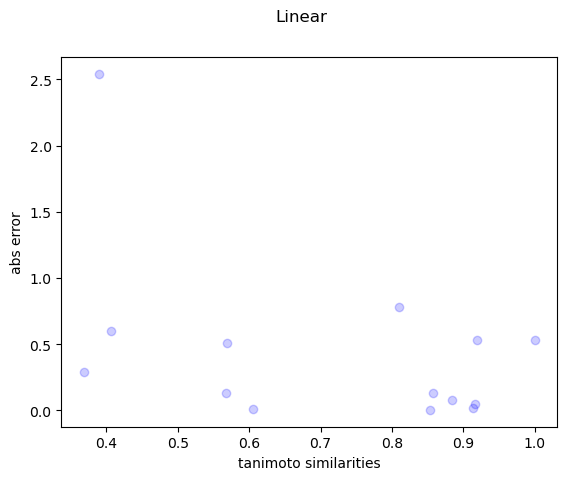

In [22]:
type_ml_use = 'linear'
reg, plot_title = model_choice(type_ml_use)
param_tuning(type_ml_use, reg)

using ML type KRR
KRR {'alpha': 10.0, 'gamma': 0.03359818286283774, 'kernel': 'laplacian'}
MAE train: 0.4568
MAE test: 0.3940


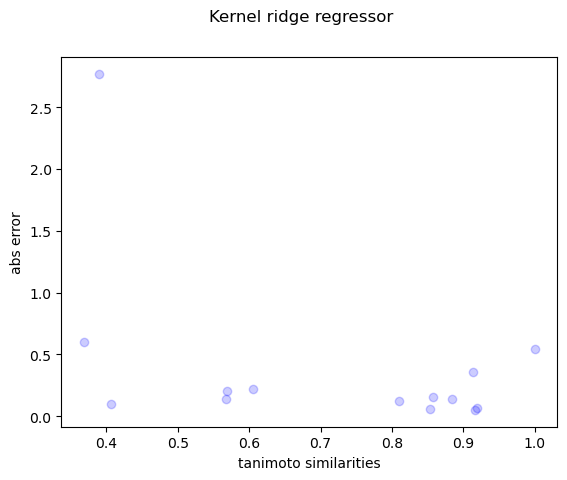

In [23]:
type_ml_use = 'KRR'
reg, plot_title = model_choice(type_ml_use)
param_tuning(type_ml_use, reg)

using ML type RF
RF {'max_depth': 2, 'max_features': 'log2', 'n_estimators': 10}
MAE train: 0.4656
MAE test: 0.4178


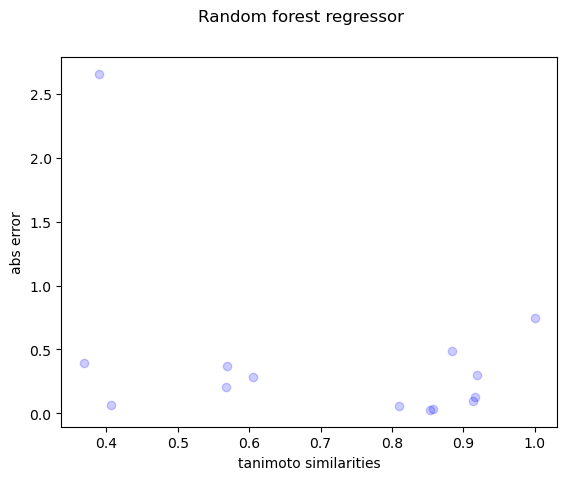

In [24]:
type_ml_use = 'RF'
reg, plot_title = model_choice(type_ml_use)
param_tuning(type_ml_use, reg)

using ML type GB
GB {'learning_rate': 0.05, 'max_depth': 1, 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 20}
MAE train: 0.4758
MAE test: 0.5178


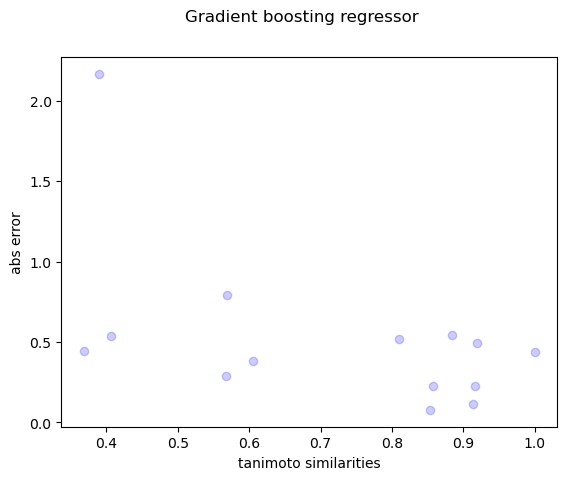

In [25]:
type_ml_use = 'GB'
reg, plot_title = model_choice(type_ml_use)
param_tuning(type_ml_use, reg)

using ML type ANN
ANN {'hidden_layer_sizes': [5, 5, 5], 'learning_rate_init': 0.01}
MAE train: 0.3517
MAE test: 0.3500


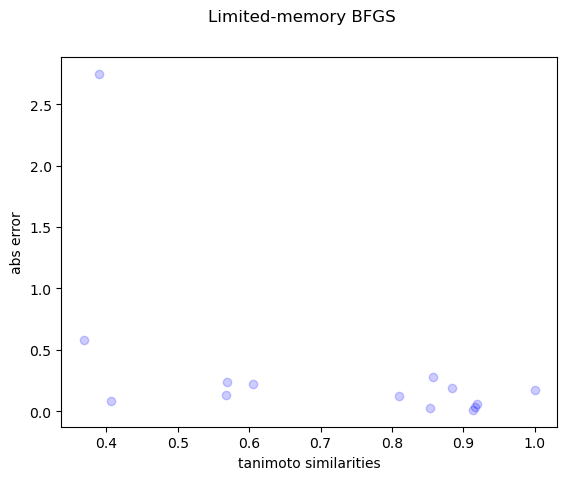

In [26]:
type_ml_use = 'ANN'
reg, plot_title = model_choice(type_ml_use)
param_tuning(type_ml_use, reg)

In [27]:
def mean_error(type_ml_use, reg):
    if type_ml_use == 'linear':
        param_grid = {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 1}
        reg = linear_model.ElasticNet()

    if type_ml_use=='KRR':
        param_grid= {'alpha': 10.0, 'gamma': 0.03359818286283774, 'kernel': 'laplacian'}
        reg = KernelRidge()

    if type_ml_use=='GB':
        param_grid = {'learning_rate': 0.05, 'max_depth': 1, 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 20}
        reg = GradientBoostingRegressor()

    if type_ml_use=='RF':
        param_grid = {'max_depth': 2, 'max_features': 'log2', 'n_estimators': 20}
        reg = RandomForestRegressor()

    if type_ml_use=='ANN':
        param_grid = {'hidden_layer_sizes': [10], 'learning_rate_init': 0.05}
        reg = MLPRegressor()

    reg.fit(x_train, y_train)
    # vypocitat novy MAE train, test po hyperparameter trainink
    y_train_predict = reg.predict(x_train)
    y_test_predict = reg.predict(x_test)
    train_error = np.mean(np.abs(y_train_predict-y_train))
    abs_error = np.abs(y_test_predict-y_test)
    test_error = np.mean(abs_error)
    
    return y_test_predict

In [84]:
def model_choice_hyperparams_tuned(ml_type):
    
    if ml_type == 'linear':
        reg = linear_model.ElasticNet(alpha = 0.01, fit_intercept = True, l1_ratio = 1)
        plot_title = "Linear"
        
    if ml_type == 'KRR':
        reg = KernelRidge(alpha = 10.0, gamma = 0.03359818286283774, kernel = "laplacian")
        plot_title = "Kernel ridge regressor"
        
    if ml_type == 'RF':
        reg = RandomForestRegressor(max_depth = 2, max_features = 'log2', n_estimators = 20)
        plot_title = "Random forest regressor"
        
    if ml_type == 'GB':
        reg = GradientBoostingRegressor(learning_rate = 0.05, max_depth = 1, min_samples_leaf = 20, min_samples_split = 5, n_estimators = 20)
        plot_title = "Gradient boosting regressor"
        
    if ml_type == 'ANN':
        reg = MLPRegressor(hidden_layer_sizes = [10], learning_rate_init = 0.05)
        plot_title = "Limited-memory BFGS"
    print(f"using ML type {ml_type}")
    
    return reg, plot_title

In [97]:
reg, plot_title = model_choice_hyperparams_tuned("linear")
y_test_linear_final = []
for i in range(5):
    y_test_linear = mean_error(type_ml_use, reg)
    y_test_linear_final.append(y_test_linear)
mol_avg_error = np.average(y_test_linear_final, axis = 0)
standard_deviation_linear = np.std(y_test_linear_final, axis = 1)
print(f"average molecule error: {mol_avg_error}\n standard deviation: {standard_deviation_linear}")

using ML type linear
average molecule error: [ 0.64177837  0.36274231  0.66675613  0.50701051  0.15372822  0.31402218
  0.39132412  0.39482797  0.57262402  0.29250196  0.04648538  0.30610199
 -0.08350485 -0.14582205]
 standard deviation: [0.22881342 0.32885003 0.3715734  0.3227781  0.30280014]


In [103]:
reg, plot_title = model_choice_hyperparams_tuned("KRR")
y_test_KRR_final = []
for i in range(5):
    y_test_KRR = mean_error(type_ml_use, reg)
    y_test_KRR_final.append(y_test_KRR)
mol_avg_error = np.average(y_test_KRR_final, axis = 0)
standard_deviation_KRR = np.std(y_test_KRR_final, axis = 1)
print(f"average molecule error: {mol_avg_error}\n standard deviation: {standard_deviation_linear}")

using ML type KRR
average molecule error: [ 0.27407907  0.34421866  0.70177656  0.64225166 -0.00474538  0.32511005
  0.42998738  0.35047526  0.5600155   0.29442673  0.11952533  0.15330847
  0.17096946 -0.09179428]
 standard deviation: [0.22881342 0.32885003 0.3715734  0.3227781  0.30280014]


In [104]:
reg, plot_title = model_choice_hyperparams_tuned("RF")
y_test_RF_final = []
for i in range(5):
    y_test_RF = mean_error(type_ml_use, reg)
    y_test_RF_final.append(y_test_RF)
mol_avg_error = np.average(y_test_RF_final, axis = 0)
standard_deviation_RF = np.std(y_test_RF_final, axis = 1)
print(f"average molecule error: {mol_avg_error}\n standard deviation: {standard_deviation_linear}")

using ML type RF
average molecule error: [ 0.38357841  0.50579196  0.46409576  0.55594415 -0.22277451  0.4008001
  0.36570959  0.46091468  0.60190217  0.3174592  -0.22435071 -0.01824403
  0.11701807  0.27921295]
 standard deviation: [0.22881342 0.32885003 0.3715734  0.3227781  0.30280014]


In [106]:
reg, plot_title = model_choice_hyperparams_tuned("GB")
y_test_GB_final = []
for i in range(5):
    y_test_GB = mean_error(type_ml_use, reg)
    y_test_GB_final.append(y_test_GB)
mol_avg_error = np.average(y_test_GB_final, axis = 0)
standard_deviation_GB = np.std(y_test_GB_final, axis = 1)
print(f"average molecule error: {mol_avg_error}\n standard deviation: {standard_deviation_linear}")

using ML type GB
average molecule error: [ 0.31945982  0.25090459  0.56654226  0.49362285  0.04772355  0.34426161
  0.41485186  0.2842524   0.49047316  0.21656982 -0.06152099  0.31073681
  0.26334823 -0.04282957]
 standard deviation: [0.22881342 0.32885003 0.3715734  0.3227781  0.30280014]


In [107]:
reg, plot_title = model_choice_hyperparams_tuned("ANN")
y_test_ANN_final = []
for i in range(5):
    y_test_ANN = mean_error(type_ml_use, reg)
    y_test_ANN_final.append(y_test_ANN)
mol_avg_error = np.average(y_test_ANN_final, axis = 0)
standard_deviation_ANN = np.std(y_test_ANN_final, axis = 1)
print(f"average molecule error: {mol_avg_error}\n standard deviation: {standard_deviation_linear}")

using ML type ANN
average molecule error: [ 0.42015921  0.34441965  0.61760703  0.53869622  0.07347947  0.36410303
  0.36312298  0.47657891  0.451975    0.30097196  0.16259462 -0.05105649
  0.02309891 -0.11336281]
 standard deviation: [0.22881342 0.32885003 0.3715734  0.3227781  0.30280014]
